# https://www.kaggle.com/code/amjadbakri/fr-to-en-transformers-from-scratch-with-tensorflow/notebook

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
import os
import re
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [8]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [11]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ROSPL PRJ/eng_-french.csv")
# df["French words/sentences"]=("<SOS> "+df["French words/sentences"]+" <EOS>")
# df["English words/sentences"]=("<SOS> "+df["English words/sentences"]+" <EOS>")
df=df.sample(frac=1).reset_index(drop=True)
df

,English words/sentences,French words/sentences
0,Tom is in a meeting right now.,Tom est actuellement en réunion.
1,I want Tom to go get me something to eat.,Je veux que Tom aille me chercher quelque chos...
2,The boys worked hard.,Les garçons travaillaient dur.
3,Who wants it?,Qui en veut ?
4,Sweep my room.,Va balayer ma chambre.
...,...,...
175616,"We estimated the damage at $1,000.",Nous avons estimé les dommages à 1 000 $.
175617,I hear everything you're saying.,J'entends tout ce que vous dites.
175618,You must be very special.,Tu dois être vraiment spéciale.
175619,Just try it out.,Essayez-le simplement !


In [12]:
df["French word numbers"]=(df['English words/sentences'].str.split().apply(len))
df["English word numbers"]=(df['French words/sentences'].str.split().apply(len))

<Axes: >

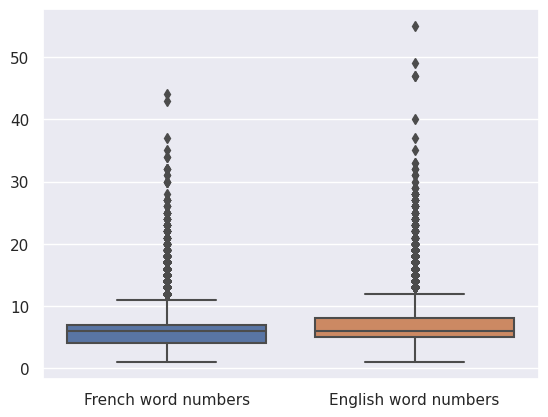

In [13]:
data_to_plot = df[["French word numbers", "English word numbers"]]
sns.boxplot(data=data_to_plot)

(0.0, 40.0)

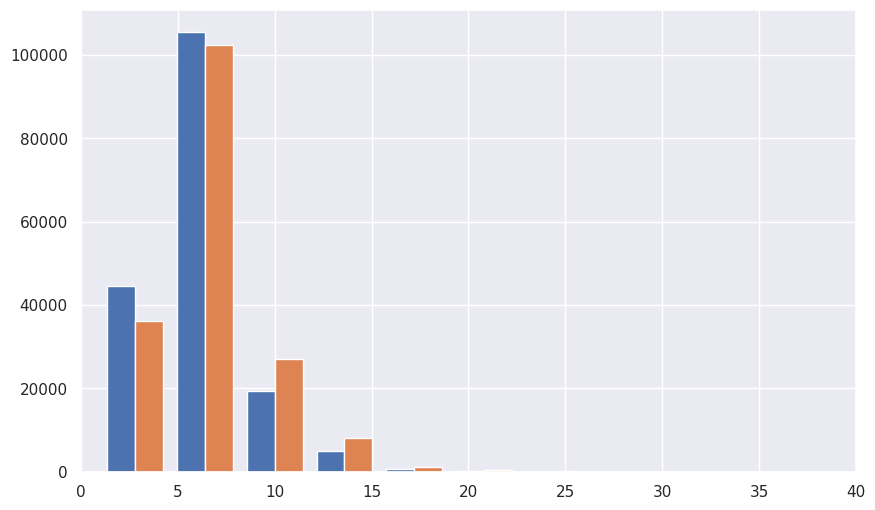

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(data_to_plot, bins=15, alpha=1)
plt.xlim(0, 40)

In [15]:
eng = df['English words/sentences']
fr = df['French words/sentences']

In [16]:
english_words_counter = collections.Counter([word for sentence in eng for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in fr for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in eng for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in fr for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1082098 English words.
27393 unique English words.
10 Most common words in the English dataset:
"I" "to" "you" "the" "a" "is" "Tom" "of" "in" "have"

1177832 French words.
44918 unique French words.
10 Most common words in the French dataset:
"de" "Je" "?" "pas" "que" "à" "ne" "la" "le" "Il"


In [17]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [18]:
def pad(x, length=14):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

In [19]:
def clean_text(text):
    cleaned_texts=[]
    for sent in text:
        cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', sent)
        cleaned_texts.append(cleaned_text)
    return cleaned_texts

In [20]:
def preprocess(x, y):
#     cleaned_x=remove_stop(x,"english")
#     cleaned_y=remove_stop(y,"french")

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [21]:
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(eng, fr)

In [22]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Max English sentence length: 14
Max French sentence length: 14
English vocabulary size: 14531
French vocabulary size: 30660


In [23]:
class positional_encoding(tf.keras.layers.Layer):
    def __init__(self,max_sentence_len,embedding_size,**kwargs):
        super().__init__(**kwargs)

        self.pos=np.arange(max_sentence_len).reshape(1,-1).T
        self.i=np.arange(embedding_size/2).reshape(1,-1)
        self.pos_emb=np.empty((1,max_sentence_len,embedding_size))
        self.pos_emb[:,:,0 : :2]=np.sin(self.pos / np.power(10000, (2 * self.i / embedding_size)))
        self.pos_emb[:,:,1 : :2]=np.cos(self.pos / np.power(10000, (2 * self.i / embedding_size)))
        self.positional_embedding = tf.cast(self.pos_emb,dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_embedding

In [24]:
class paddding_mask(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def call(self,inputs):
        mask=1-tf.cast(tf.math.equal(inputs,0),tf.float32)
        return mask[:, tf.newaxis, :]

In [25]:
class create_look_ahead_mask(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def call(self,sequence_length):
        mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
        return mask

In [26]:
class input_layer_encoder(tf.keras.layers.Layer):
    def __init__(self,max_sentence_len,embedding_size,vocab_size,**kwargs):
        super().__init__(**kwargs)
        self.paddding_mask=paddding_mask()

        self.embedding=tf.keras.layers.Embedding(vocab_size,
                                                 embedding_size,
                                                 input_length=max_sentence_len,
                                                 input_shape=(max_sentence_len,))

        self.positional_encoding=positional_encoding(max_sentence_len,embedding_size)
    def call(self,inputs):
        mask=self.paddding_mask(inputs)

        emb=self.embedding(inputs)

        emb=self.positional_encoding(emb)
        return emb,mask

In [27]:
class input_layer_decoder(tf.keras.layers.Layer):
    def __init__(self,max_sentence_len,embedding_size,vocab_size,**kwargs):
        super().__init__(**kwargs)
        self.paddding_mask=paddding_mask()

        self.embedding=tf.keras.layers.Embedding(vocab_size,
                                                 embedding_size,
                                                 input_length=max_sentence_len,
                                                 input_shape=(max_sentence_len,))

        self.positional_encoding=positional_encoding(max_sentence_len,embedding_size)

        self.look_ahead_mask=create_look_ahead_mask()
        self.max_sentence_len=max_sentence_len
    def call(self,inputs):
        mask=self.paddding_mask(inputs)

        emb=self.embedding(inputs)

        emb=self.positional_encoding(emb)

        look_head_mak=self.look_ahead_mask(self.max_sentence_len)
        look_head_mak=tf.bitwise.bitwise_and(tf.cast(look_head_mak,dtype=np.int8),tf.cast(mask,dtype=np.int8))
        return emb,look_head_mak

In [28]:
class Encoder_layer(tf.keras.layers.Layer):
    def __init__(self,
                 embedding_size,
                 heads_num,
                 dense_num,
                 dropout_rate=0.0,
                 **kwargs):

        super().__init__(**kwargs)


        self.multi_attention=tf.keras.layers.MultiHeadAttention(
                num_heads=heads_num,
                key_dim=embedding_size,
                dropout=dropout_rate,
            )

        self.Dropout=tf.keras.layers.Dropout(dropout_rate)

        self.ff=tf.keras.Sequential([
            tf.keras.layers.Dense(dense_num,activation="relu"),
            tf.keras.layers.Dense(dense_num,activation="relu"),
            tf.keras.layers.Dense(dense_num,activation="relu"),
            tf.keras.layers.Dense(embedding_size,activation="relu"),
            tf.keras.layers.Dropout(dropout_rate)
        ])

        self.add=tf.keras.layers.Add()

        self.norm1=tf.keras.layers.LayerNormalization()
        self.norm2=tf.keras.layers.LayerNormalization()
    def call(self,inputs,mask,training):

        mha=self.multi_attention(inputs,inputs,inputs,mask)

        norm=self.norm1(self.add([inputs,mha]))

        fc=self.ff(norm)

        A=self.Dropout(fc,training=training)

        output=self.norm2(self.add([A,norm]))

        return output

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 max_sentence_len,
                 embedding_size,
                 vocab_size,
                 heads_num,
                 dense_num,
                 num_of_encoders,
                 **kwargs):
        super().__init__(**kwargs)
        self.add=tf.keras.layers.Add()
        self.input_layer=input_layer_encoder(max_sentence_len,embedding_size,vocab_size)
        self.encoder_layer=[Encoder_layer(embedding_size,heads_num, dense_num) for i in range (num_of_encoders)]
        self.num_layers=num_of_encoders
    def call(self,inputs,training):
        emb,mask=self.input_layer(inputs)
        skip=emb
        for layer in self.encoder_layer:
            emb = layer(emb, mask,training)
            emb = self.add([skip,emb])
            skip = emb
        return emb,mask

In [30]:
class decoder_layer(tf.keras.layers.Layer):
    def __init__(self,
                 embedding_size,
                 heads_num,
                 dense_num,
                 dropout_rate=0.0,
                 **kwargs):

        super().__init__(**kwargs)

        self.masked_mha=tf.keras.layers.MultiHeadAttention(
                num_heads=heads_num,
                key_dim=embedding_size,
                dropout=dropout_rate,
            )


        self.multi_attention=tf.keras.layers.MultiHeadAttention(
                num_heads=heads_num,
                key_dim=embedding_size,
                dropout=dropout_rate,
            )

        self.ff=tf.keras.Sequential([
            tf.keras.layers.Dense(dense_num,activation="relu"),
            tf.keras.layers.Dense(dense_num,activation="relu"),
            tf.keras.layers.Dense(dense_num,activation="relu"),
            tf.keras.layers.Dense(embedding_size,activation="relu"),
            tf.keras.layers.Dropout(dropout_rate)
        ])

        self.Dropout=tf.keras.layers.Dropout(dropout_rate)
        self.add=tf.keras.layers.Add()

        self.norm1=tf.keras.layers.LayerNormalization()
        self.norm2=tf.keras.layers.LayerNormalization()
        self.norm3=tf.keras.layers.LayerNormalization()

    def call(self,inputs,encoder_output,enc_mask,look_head_mask,training):

        mha_out,atten_score=self.masked_mha(inputs,inputs,inputs,look_head_mask,return_attention_scores=True)

        Q1=self.norm1(self.add([inputs,mha_out]))

        mha_out2,atten_score2=self.multi_attention(Q1,encoder_output,encoder_output,enc_mask,return_attention_scores=True)

        Z=self.norm2(self.add([Q1,mha_out2]))

        fc =  self.ff(Z)

        A=self.Dropout(fc,training=training)

        output=self.norm3(self.add([A,Z]))
        return output

In [31]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 max_sentence_len,
                 embedding_size,
                 vocab_size,
                 heads_num,
                 dense_num,
                 num_of_decoders,
                 **kwargs):
        super().__init__(**kwargs)
        self.add=tf.keras.layers.Add()
        self.input_layer=input_layer_decoder(max_sentence_len,embedding_size,vocab_size)
        self.decoder_layer=[decoder_layer(embedding_size,heads_num, dense_num) for i in range (num_of_decoders)]
        self.num_layers=num_of_decoders
    def call(self,inputs,encoder_output,enc_mask,training):
        emb,look_head_mask=self.input_layer(inputs)
        skip=emb
        for layer in self.decoder_layer:
            emb = layer(emb,encoder_output,enc_mask,look_head_mask,training)
            emb = self.add([skip,emb])
            skip = emb
        return emb

In [32]:
class transformer(tf.keras.Model):
    def __init__(self,
                 max_sentence_len_1=None,
                 max_sentence_len_2=None,
                 embedding_size=None,
                 vocab_size1=None,
                 vocab_size2=None,
                 heads_num=None,
                 dense_num=None,
                 num_of_encoders_decoders=None):

        super(transformer,self).__init__()

        self.Encoder=Encoder(max_sentence_len_1,
                             embedding_size,
                             vocab_size1,
                             heads_num,
                             dense_num,
                             num_of_encoders_decoders)

        self.Decoder=Decoder(max_sentence_len_2,
                             embedding_size,
                             vocab_size2,
                             heads_num,
                             dense_num,
                             num_of_encoders_decoders,)

        self.Final_layer=tf.keras.layers.Dense(vocab_size2, activation='relu')

        self.softmax=tf.keras.layers.Softmax(axis=-1)
    def call(self, inputs):
        input_sentence,output_sentence=inputs
        enc_output,enc_mask=self.Encoder(input_sentence)

        dec_output=self.Decoder(output_sentence,enc_output,enc_mask)

        final_out=self.Final_layer(dec_output)

        softmax_out=self.softmax(final_out)
        return softmax_out

In [33]:
tran=transformer(max_sentence_len_1=14,
                     max_sentence_len_2=13,
                     embedding_size=300,
                     vocab_size1=french_vocab_size+1,
                     vocab_size2=english_vocab_size+1,
                     heads_num=5,
                     dense_num=512,
                     num_of_encoders_decoders=2)

In [34]:
tran((preproc_french_sentences[:1],preproc_english_sentences[:1,:-1]))
tran.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  14476948  
                                                                 
 decoder (Decoder)           multiple                  13249048  
                                                                 
 dense_16 (Dense)            multiple                  4374132   
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 32100128 (122.45 MB)
Trainable params: 32100128 (122.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
tran.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=["accuracy"])

In [ ]:
tran.fit((preproc_french_sentences,preproc_english_sentences[:,:-1]),
         preproc_english_sentences[:,1:,tf.newaxis],
         epochs=20,#30
         batch_size=1024)

Epoch 1/20
116/172 [===================>..........] - ETA: 49s - loss: 3.2774 - accuracy: 0.6040

In [ ]:
tran.fit((preproc_french_sentences,preproc_english_sentences[:,:-1]),
         preproc_english_sentences[:,1:,tf.newaxis],
         epochs=10,#30
         batch_size=1024)

Epoch 1/10
172/172 [==============================] - 145s 844ms/step - loss: 0.6436 - accuracy: 0.9139
Epoch 2/10
172/172 [==============================] - 144s 838ms/step - loss: 0.6344 - accuracy: 0.9159
Epoch 3/10
172/172 [==============================] - 145s 842ms/step - loss: 0.6271 - accuracy: 0.9176
Epoch 4/10
172/172 [==============================] - 144s 838ms/step - loss: 0.6225 - accuracy: 0.9183
Epoch 5/10
172/172 [==============================] - 144s 838ms/step - loss: 0.6158 - accuracy: 0.9199
Epoch 6/10
172/172 [==============================] - 144s 839ms/step - loss: 0.6148 - accuracy: 0.9200
Epoch 7/10
172/172 [==============================] - 144s 838ms/step - loss: 0.6060 - accuracy: 0.9219
Epoch 8/10
172/172 [==============================] - 145s 842ms/step - loss: 0.6014 - accuracy: 0.9231
Epoch 9/10
172/172 [==============================] - 144s 839ms/step - loss: 0.5983 - accuracy: 0.9237
Epoch 10/10
172/172 [==============================] - 144s 838m

In [1]:
def prepare_pred(sent):
    output=english_tokenizer.texts_to_sequences(sent)
    output=pad(output,13)
    return output

In [2]:
def pred(i):
    sent=[""]
    french_token=prepare_pred(sent)
    word=np.argmax(tran.predict((preproc_french_sentences[[i]],french_token),verbose=0),-1)[0,0]
    sent[0]=sent[0]+ " "+english_tokenizer.sequences_to_texts(np.array([[word]]))[0]
    for j in range(1,12):
        french_token=prepare_pred(sent)
        word=np.argmax(tran.predict((preproc_french_sentences[[i]],french_token),verbose=0),-1)[0,j]
        sent[0]=sent[0]+ " "+english_tokenizer.sequences_to_texts(np.array([[word]]))[0]
        if english_tokenizer.sequences_to_texts(np.array([[word]]))[0]=="eos":
            break
    return sent

In [3]:
import random

In [4]:
def show():
    i=random.randint(0,170111)
    print("french sent : ",french_tokenizer.sequences_to_texts(preproc_french_sentences[[i]]))
    print("predict sent : ",pred(i))
    print("true sent : ",english_tokenizer.sequences_to_texts(preproc_english_sentences[[i]]))

In [36]:
for i in range(5):
    show()
    print("----------------")

french sent :  ['allume le cierge']
predict sent :  [' dwells dwells dwells dwells adding greeted core separate separate separate eavesdrop eavesdrop']
true sent :  ['light the candle']
----------------
french sent :  ['vous voulez cela non']
predict sent :  [' dwells dwells dwells dwells adding greeted core separate separate separate eavesdrop eavesdrop']
true sent :  ["you do want that don't you"]
----------------
french sent :  ["j'apprécie tout ce que tu peux faire"]
predict sent :  [' dwells dwells dwells dwells adding greeted core separate separate eavesdrop eavesdrop eavesdrop']
true sent :  ['i appreciate anything you can do']
----------------
french sent :  ['tom arriva sans encombre']
predict sent :  [' dwells dwells dwells dwells adding greeted core separate separate separate eavesdrop eavesdrop']
true sent :  ['tom arrived safely']
----------------
french sent :  ['notre école compte environ mille étudiants']
predict sent :  [' dwells dwells dwells dwells adding greeted cor

In [38]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 41.3 MB/s eta 0:00:00


In [71]:
tran.save('tran.tf',save_format="tf")

In [77]:
# Translate the text.
translated_sentence = translation_pipeline("Je suis un étudiant.")

# Print the translated sentence.
print(translated_sentence)

[{'translation_text': 'Je suis un étudiant.'}]


In [85]:
!pip install textblob googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=9180a1f48dba9900c7b851e21bc265aa1701346f1020f45a35ab8e9724bb1bd6
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [87]:
from googletrans import Translator

# Function to translate text
def translate_text(text, target_language='en'):
    translator = Translator()
    translated = translator.translate(text, dest=target_language)
    return translated.text

SENTIMENT ANALYSIS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ROSPL PRJ/DATA/Reviews.csv")
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [7]:
print(df.shape)

(568454, 10)


In [8]:
df = df.head(500)
print(df.shape)

(500, 10)


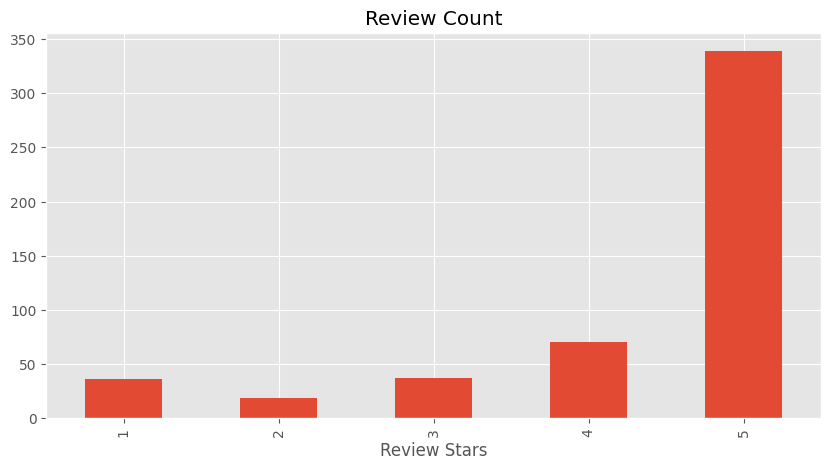

In [9]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Review Count',figsize=(10,5))

ax.set_xlabel('Review Stars')
plt.show()

In [10]:
eg = df['Text'][50]
print(eg)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [11]:
tokens = nltk.word_tokenize(eg)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [12]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [13]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


In [14]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores("I am so happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [17]:
sia.polarity_scores("This is so horrible")

{'neg': 0.6, 'neu': 0.4, 'pos': 0.0, 'compound': -0.6696}

In [18]:
sia.polarity_scores(eg)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [20]:
#run polarity scores on entire dataset
res = {}
for i,row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
res

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441},
 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664},
 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265},
 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468},
 6: {'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883},
 7: {'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346},
 8: {'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487},
 9: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369},
 10: {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313},
 11: {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746},
 12: {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'compound': -0.7579},
 13: {'neg': 0.031, 'neu': 0.923, 'pos': 0.046, 'compound': 0.296},
 14: {'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.9466},
 15: {'neg': 0.104, 'neu': 0.632, 'pos': 0.264, 'compound': 0.6486},
 

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
#now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


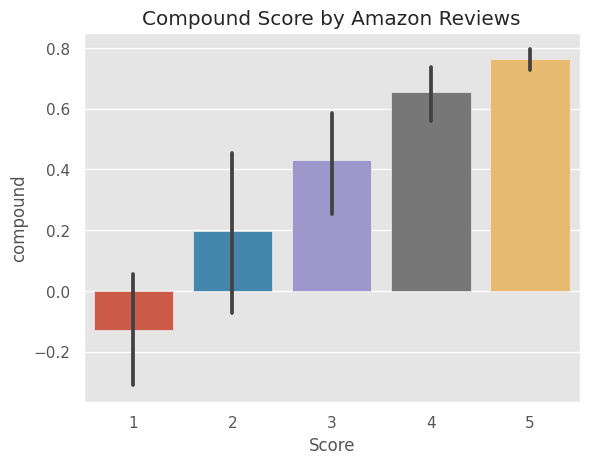

In [ ]:
ax = sns.barplot(data = vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Reviews')
plt.show()

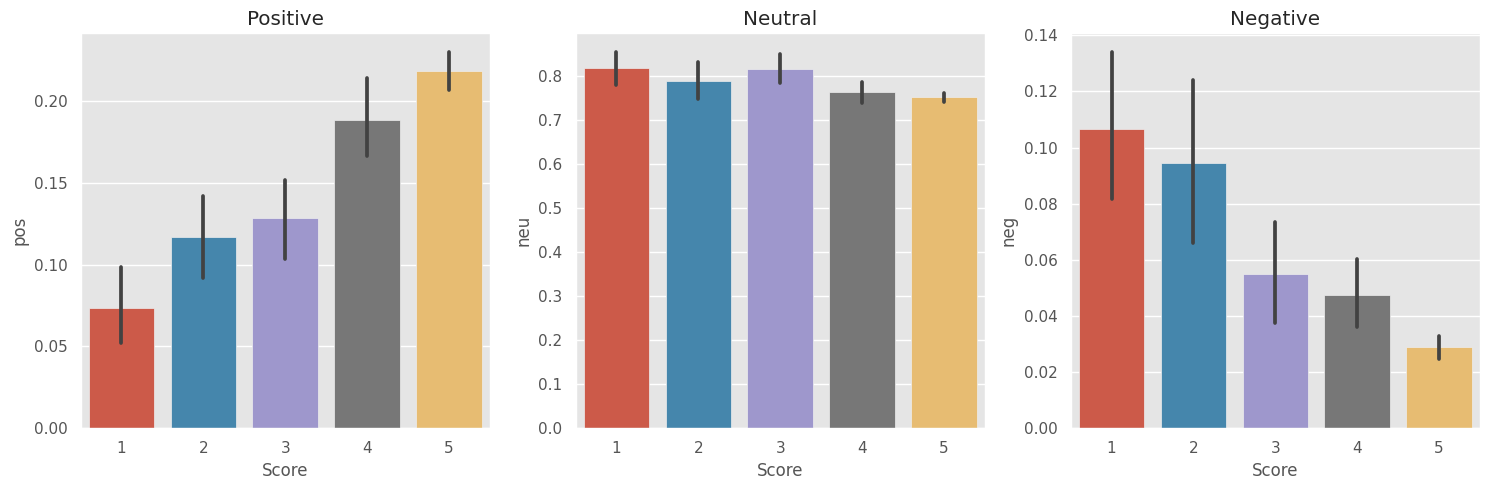

In [ ]:
fig, axs = plt.subplots(1, 3, figsize =(15,5))
sns.barplot(data = vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data = vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data = vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

In [35]:
!pip install transformers

     ---------------------------------------- 0.0/121.5 kB ? eta -:--:--
     ---------- ----------------------------- 30.7/121.5 kB ? eta -:--:--
     ----------------------------- --------- 92.2/121.5 kB 1.3 MB/s eta 0:00:01
     --------------------------------- -- 112.6/121.5 kB 939.4 kB/s eta 0:00:01
     --------------------------------- -- 112.6/121.5 kB 939.4 kB/s eta 0:00:01
     --------------------------------- -- 112.6/121.5 kB 939.4 kB/s eta 0:00:01
     ------------------------------------ 121.5/121.5 kB 445.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.7 MB 1.3 MB/s eta 0:00:06
    --------------------------------------- 0.1/7.7 MB 939.4 kB/s eta 0:00:09
    --------------------------------------- 0.1/7.7 MB 939.4 kB/s eta 0:00:09
    --------------------------------------- 0.2/7.7 MB 807.1 kB/s eta 0:00:10
   - 

In [38]:
!pip install scipy

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------------- -------------------------- 20.5/60.4 kB ? eta -:--:--
     -------------------------------------- 60.4/60.4 kB 643.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/44.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.1 MB 1.6 MB/s eta 0:00:28
   ---------------------------------------- 0.2/44.1 MB 1.7 MB/s eta 0:00:27
   ---------------------------------------- 0.2/44.1 MB 1.7 MB/s eta 0:00:26
   ---------------------------------------- 0.3/44.1 MB 1.1 MB/s eta 0:00:40
   ---------------------------------------- 0.4/44.1 MB 1.4 MB/s eta 0:00:32
   ---------------------------------------- 0.5/44.1 MB 1.5 MB/s eta 0:00:29
   ---------------------------------------- 0.5/44.1 MB 1.5 MB/s eta 0:00:30
    --------------------------------------- 0.6/44.1 MB 1.4 MB/s eta 0:00:32
    ---------------

In [54]:
!pip install torch

     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB 1.9 MB/s eta 0:00:03
      --------------------------------------- 0.1/5.7 MB 1.1 MB/s eta 0:00:06
      --------------------------------------- 0.1/5.7 MB 1.1 MB/s eta 0:00:06
     - -------------------------------------- 0.2/5.7 MB 1.2 MB/s eta 0:00:05
     - -------------------------------------- 0.3/5.7 MB 1.3 MB/s eta 0:00:05
     -- ------------------------------------- 0.3/5.7 MB 1.3 MB/s eta 0:00:05
     -- ------------------------------------- 0.4/5.7 MB 1.3 MB/s eta 0:00:05
     --- ------------------------------------ 0.5/5.7 MB 1.4 MB/s eta 0:00:04
     --- ------------------------------------ 0.5/5.7 MB 1.4 MB/s eta 0:00:04
     ---- ----------------------------------- 0.6/5.7 MB 1.4 MB/s eta 0:00:04
     ---- ----------------------------------- 0.7/5.7 MB 1.4 MB/s eta 0:00:04
     ----- ---------------------------------- 0.7/5.7 MB 1.4 MB/s eta 0

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

c:\Users\shrey\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Users\shrey\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shrey\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
#VADER results on example
print(eg)
sia.polarity_scores(eg)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Roberta Model results for example
encoded_text = tokenizer(eg, return_tensors="pt")
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.002957372}


In [42]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors="pt")
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'roberta_neg': scores[0],
      'roberta_neu': scores[1],
      'roberta_pos': scores[2]
  }

  return scores_dict


In [44]:
!pip install IProgress

In [48]:
res = {}
for i,row in tqdm(df.iterrows(), total=len(df)):
  try:
      text = row['Text']
      myid = row['Id']
      vader_result = sia.polarity_scores(text)
      vader_result_rename = {}
      for key,value in vader_result.items():
        vader_result_rename[f'vader_{key}'] = value
      roberta_result = polarity_scores_roberta(text)
      both = {**vader_result_rename, **roberta_result}
      res[myid] = both

  except:
    print(f'Broke for id {myid}')


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [116]:
# both = {**vader_result_rename, **roberta_result}
both

{'vader_neg': 0.0,
 'vader_neu': 0.678,
 'vader_pos': 0.322,
 'vader_compound': 0.9811,
 'roberta_neg': 0.0024397594,
 'roberta_neu': 0.011327226,
 'roberta_pos': 0.986233}

In [117]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')

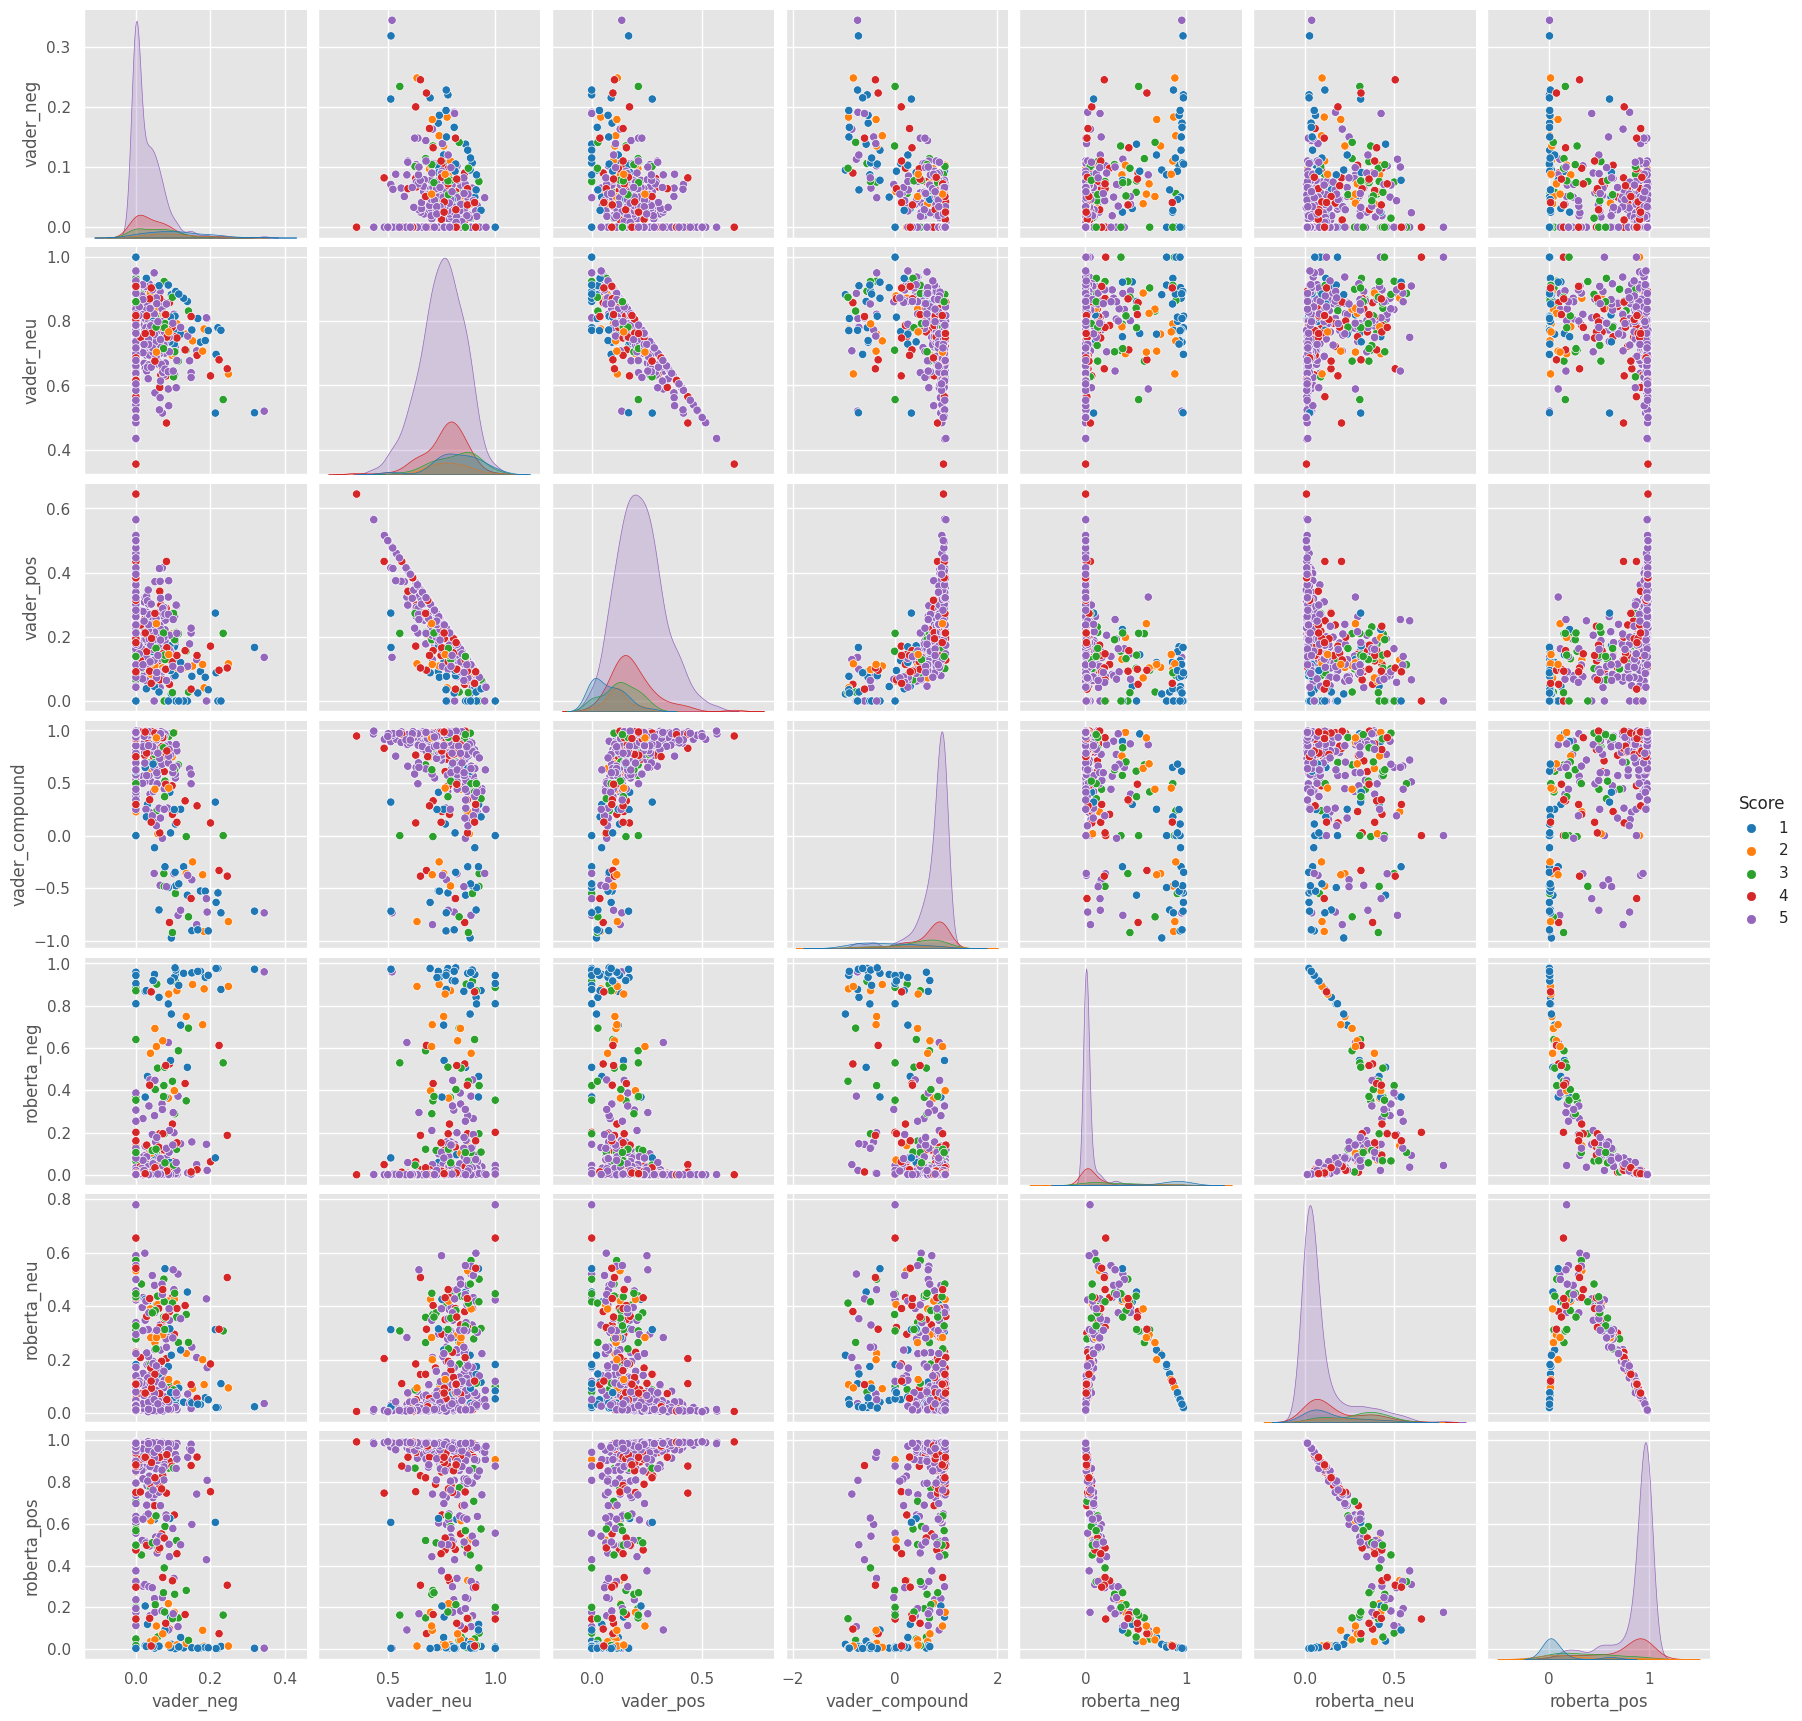

In [118]:
sns.pairplot(data = results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = 'Score',
             palette = 'tab10'
             )

plt.show()

In [119]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [120]:
input_text = input("Enter text to analyze sentiment: ")

translated_text = translate_text(input_text, target_language='en')
print("Translated Text:", translated_text)
sentiment = sent_pipeline(translated_text)
print("Sentiment:", sentiment)

Enter text to analyze sentiment:  j'apprécie tout ce que tu peux faire
Translated Text: I appreciate everything you can do
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998255372047424}]


In [121]:
input_text = input("Enter text to analyze sentiment: ")

translated_text = translate_text(input_text, target_language='en')
print("Translated Text:", translated_text)
sentiment = sent_pipeline(translated_text)
print("Sentiment:", sentiment)

Enter text to analyze sentiment: Good morning!
Translated Text: Good morning!
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998278617858887}]


SPEECH TO TEXT

In [11]:
!pip install SpeechRecognition

In [12]:
import speech_recognition as sr

recognizer = sr.Recognizer()

In [13]:
with sr.Microphone() as source:
    print("Speak something:")
    audio = recognizer.listen(source)

Speak something:


In [14]:
try:
    text = recognizer.recognize_google(audio)
    print("You said: " + text)
except sr.UnknownValueError:
    print("Google Web Speech API could not understand the audio.")
except sr.RequestError as e:
    print("Could not request results from Google Web Speech API; {0}".format(e))

You said: hello good morning
